<a href="https://colab.research.google.com/github/decile-team/submodlib/blob/master/tutorials/Quantitative_Analysis_and_Effect_of_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [6]:
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 34 kB/s 


In [1]:
import sklearn
sklearn.__version__

'0.24.2'

In [40]:
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ submodlib

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
     |████████████████████████████████| 81 kB 3.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for submodlib: filename=submodlib-1.1.3-cp37-cp37m-linux_x86_64.whl size=493470 sha256=1d5e00606ba0a308c4974bbd8b42479bf7c7ac4067f8921a099a4ee76e033f7b
  Stored in directory: /root/.cache/pip/wheels/4a/95/37/18a00ef81db9264ff3313c57dd8e57673c682ee0de44c78004
Successfully built submodlib


# Prepare Synthetic Data

In [7]:
import numpy as np
from sklearn.datasets import make_blobs
import h5py
import random

def save_dict_to_hdf5(dic, filename):
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    for key, item in dic.items():
        # print(item, type(item))
        if isinstance(item, list):
            item = np.array(item)
        # print(item, type(item))
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

n = 1005 #num points in each collection
cn = 10 #number of collections
num_qp = 5
dataset = {}
random.seed(1)
for i in range(cn):
    k=201
    cluster_std = random.randint(1,5)
    X, y, centers = make_blobs(n_samples=n, centers=k, n_features=2, cluster_std=cluster_std, 
                               center_box=(0,100), random_state=i, return_centers=True)
    #Ensuring some clusters are small and some are big so that difference in fairness is highlighted
    #X, y, centers = make_blobs(n_samples=[2, 2, 2, 1, 3, 1, 6, 7, 7, 6, 6, 6, 10, 11, 10, 10, 11, 9], 
                              #  centers=None, n_features=2, cluster_std=cluster_std, center_box=(0,100), 
                              #  random_state=i, return_centers=True)
    XMinusQuery = list(map(tuple, X)) 
    assert(len(centers)==k)
    queries = []
    query_features = []
    random_clusters = random.sample(range(k),num_qp)
    for c in range(num_qp): #select num_qp points
        crand = random_clusters[c]
        q_ind = y.tolist().index(crand) #find the ind of first point that belongs to cluster crand
        queries.append(q_ind)
        query_features.append(tuple(X[q_ind]))
        XMinusQuery.remove(tuple(X[q_ind]))
    dataset[str(i)] = {}
    dataset[str(i)]["omega"] = list(map(tuple, X)) 
    dataset[str(i)]["img_txt_embedding"] = XMinusQuery
    dataset[str(i)]["queries"] = query_features
    dataset[str(i)]["query_ind"] = queries
    dataset[str(i)]["cluster_assign"] = y.tolist()
    dataset[str(i)]["num_clusters"] = np.int64(k)
save_dict_to_hdf5(dataset, "synthetic_dataset.h5")

# Visualize Synthetic Data

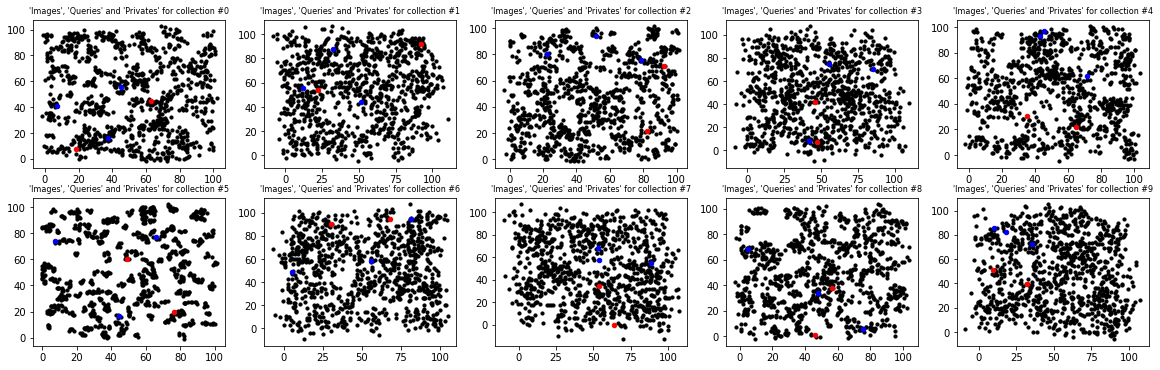

In [8]:
import matplotlib.pyplot as plt
f = h5py.File("synthetic_dataset.h5")
row = 0
index = 1
plt.figure(figsize = (20, 6))
for collection in range(cn):
  c = str(collection)
  plt.subplot(2,5,row*5+index)
  embedding = f[c]['img_txt_embedding'][:]
  embedding_x, embedding_y = embedding.T
  queriesAndPrivates = f[c]['queries'][:]
  queries = queriesAndPrivates[:3]
  privates = queriesAndPrivates[-2:]
  queries_x, queries_y = queries.T
  privates_x, privates_y = privates.T
  plotTitle = "'Images', 'Queries' and 'Privates' for collection #" + str(c)
  plt.scatter(embedding_x, embedding_y, s=10, color='black', label="Images")
  plt.scatter(queries_x, queries_y, s=20, color='blue', label = "Queries")
  plt.scatter(privates_x, privates_y, s=20, color='red', label = "Privates")
  plt.title(plotTitle, fontsize=8)
  index += 1
  if index == 6:
      row += 1
      index = 1
f.close()

# Run the experiments

In [9]:
def computeScores(divobj, budget, summary, mode, collectionNumber, f, verbose=False):
    num_queries = 3
    num_privates = 2
    if len(summary) != budget:
      raise Exception("***WARNING - lesser number of points selected")
    imageIndices = [x[0] for x in summary]
    if verbose:
      print("Selected data ground indices: ", imageIndices)
    if sum(n < 0 for n in imageIndices) > 0:
      raise Exception("***WARNING - negative indices found in greedy selection")
    fairness = -99999.99
    relevance = -99999.99
    diversity = -99999.99
    privacyIrrelevance = -99999.99
    set_num_clusters = int(f[str(collectionNumber)]['num_clusters'][()])
    if verbose:
      print("Number of clusters in dataset = ", set_num_clusters)
    image_feat = f[str(collectionNumber)]['img_txt_embedding'][:].tolist()
    omega_feat = f[str(collectionNumber)]['omega'][:].tolist()
    numZeroGain = len([x for x in summary if x[1]==0])
    imageIndicesSet = set(imageIndices)
    diversity = divobj.evaluate(imageIndicesSet)
    diversity = round(diversity,4)
    realIndices = [omega_feat.index(image_feat[x]) for x in imageIndices]
    set_cluster_assign = f[str(collectionNumber)]['cluster_assign'][:].tolist()
    clusters_covered = set()
    if mode == "query" or mode == "joint":
        set_query_ind = f[str(collectionNumber)]['query_ind'][:].tolist()
        #compute which clusters do queries belong to
        query_cluster_assign = []
        for q in set_query_ind[:num_queries]:
            query_cluster_assign.append(set_cluster_assign[q])
        queries_covered = []
        if verbose:
          print("Queries are in cluster numbers: ", query_cluster_assign)

    if mode == "private" or mode == "joint":
        set_query_ind = f[str(collectionNumber)]['query_ind'][:].tolist()
        #compute which clusters do privates belong to
        private_cluster_assign = []
        for p in set_query_ind[-num_privates:]:
            private_cluster_assign.append(set_cluster_assign[p])
        privates_covered = []
        #print("Privates are in cluster numbers: ", private_cluster_assign)

    for ele in realIndices:
        ele_cluster_assign = set_cluster_assign[ele] #which cluster does this summary point belong to
        if verbose:
          print("Summary point belongs to cluster: ", ele_cluster_assign)
        clusters_covered.add(ele_cluster_assign)
        if mode == "query" or mode == "joint":
            #check if there is a query in this cluster
            for q in query_cluster_assign:
                if(q==ele_cluster_assign):
                    queries_covered.append(q)
        if mode == "private" or mode == "joint":
            #check if there is a private in this cluster
            for p in private_cluster_assign:
                if(p==ele_cluster_assign):
                    privates_covered.append(p)
    
    if verbose:
      print("Clusters covered by the summary = ", clusters_covered)

    # diversity = len(clusters_covered)/set_num_clusters
    # diversity = round(diversity,4)

    if mode == "query" or mode == "joint":
        if verbose:
          print("Query clusters covered by the summary = ", set(queries_covered))
        fairness = len(set(queries_covered))/num_queries
        fairness = round(fairness, 4)
        if verbose:
          print("Num summary points matching query = ", len(queries_covered))
        relevance = len(queries_covered)/len(realIndices)
        relevance = round(relevance, 4)

    if mode == "private" or mode == "joint":
        #print("Num summary points matching private = ", len(privates_covered))
        privacyIrrelevance = 1 - len(privates_covered)/len(realIndices)
        privacyIrrelevance = round(privacyIrrelevance, 4)
        
    return fairness, relevance, diversity, privacyIrrelevance, numZeroGain

In [10]:
from submodlib import GraphCutFunction
from submodlib import FacilityLocationFunction
from submodlib import DisparitySumFunction
from submodlib import DisparityMinFunction
from submodlib import LogDeterminantFunction
from submodlib import FacilityLocationMutualInformationFunction
from submodlib import FacilityLocationVariantMutualInformationFunction
from submodlib import ConcaveOverModularFunction
from submodlib_cpp import ConcaveOverModular
from submodlib import GraphCutMutualInformationFunction
from submodlib import LogDeterminantMutualInformationFunction
from submodlib import GraphCutConditionalGainFunction
from submodlib import FacilityLocationConditionalGainFunction
from submodlib import LogDeterminantConditionalGainFunction
from submodlib import FacilityLocationConditionalMutualInformationFunction
from submodlib import LogDeterminantConditionalMutualInformationFunction

def create_object(mode, function, n, param, dataset, collection, 
                          query, private, magnificationEta, privacyHardness, queryDiversityLambda):
  groundData = f[str(collection)]['img_txt_embedding'][:]
  if mode == "generic":
    if function == "GC":
      return GraphCutFunction(n=n, mode="dense", lambdaVal=param, data=groundData, metric="euclidean")
    elif function == "FL":
      return FacilityLocationFunction(n=n, data=groundData, mode="dense", metric="euclidean")
    elif function == "DSUM":
      return DisparitySumFunction(n=n, data=groundData, mode="dense", metric="euclidean")
    elif function == "DMIN":
      return DisparityMinFunction(n=n, data=groundData, mode="dense", metric="euclidean")
    elif function == "LOGDET":
      return LogDeterminantFunction(n=n, data=groundData, mode="dense", metric="euclidean", lambdaVal=param)
  elif mode == "query":
    queryPrivateData = f[str(collection)]['queries'][:]
    queryData = queryPrivateData[:len(query)]
    if function == "GC":
      return GraphCutMutualInformationFunction(n=n, num_queries=len(query), data=groundData, 
                                        queryData=queryData, 
                                        metric="euclidean")
    elif function == "FL1":
      return FacilityLocationMutualInformationFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, metric="euclidean", 
                                                    magnificationEta=magnificationEta)
    elif function == "FL2":
      return FacilityLocationVariantMutualInformationFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, metric="euclidean", queryDiversityEta=queryDiversityLambda)
    elif function == "LOGDET":
      return LogDeterminantMutualInformationFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, metric="euclidean", 
                                                    magnificationEta=magnificationEta, lambdaVal=param)
    elif function == "COM1":
      return ConcaveOverModularFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, 
                                     metric="euclidean", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.logarithmic)
    elif function == "COM2":
      return ConcaveOverModularFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, 
                                     metric="euclidean", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.squareRoot)
    elif function == "COM3":
      return ConcaveOverModularFunction(n=n, num_queries=len(query), data=groundData, 
                                                    queryData=queryData, 
                                     metric="euclidean", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.inverse)
  elif mode == "private":
    queryPrivateData = f[str(collection)]['queries'][:]
    privateData = queryPrivateData[-len(private):]
    if function == "FL":
      return FacilityLocationConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          data=groundData,
                                          privateData=privateData,
                                          metric="euclidean", 
                                          privacyHardness=privacyHardness)
    elif function == "GC":
      return GraphCutConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          lambdaVal=param, 
                                          data=groundData,
                                          privateData=privateData,
                                          metric="euclidean", 
                                          privacyHardness=privacyHardness)
    elif function == "LOGDET":
      return LogDeterminantConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          lambdaVal=param,
                                          data=groundData,
                                          privateData=privateData,
                                          metric="euclidean", 
                                          privacyHardness=privacyHardness)
  elif mode == "joint":
    queryPrivateData = f[str(collection)]['queries'][:]
    queryData = queryPrivateData[:len(query)]
    privateData = queryPrivateData[-len(private):]
    if function == "FL":
      return FacilityLocationConditionalMutualInformationFunction(n=n, 
                                                                   num_queries=len(query), 
                                                                   num_privates=len(private), 
                                                                   data=groundData, 
                                                                   queryData=queryData, 
                                                                   privateData=privateData,  
                                                                   metric="euclidean",
                                                                  magnificationEta=magnificationEta,
                                                                  privacyHardness=privacyHardness)
    elif function == "LOGDET":
      return LogDeterminantConditionalMutualInformationFunction(n=n, 
                                                                   num_queries=len(query), 
                                                                   num_privates=len(private), 
                                                                   data=groundData, 
                                                                   queryData=queryData, 
                                                                   privateData=privateData,  
                                                                   metric="euclidean",
                                                                  magnificationEta=magnificationEta,
                                                                  privacyHardness=privacyHardness, lambdaVal=param)

# Checking the computation of scores

In [11]:
def showQueryClusters(f, collectionNumber, queryNumber):
  c = str(collectionNumber)
  embedding = f[c]['img_txt_embedding'][:]
  embedding_x, embedding_y = embedding.T
  queriesAndPrivates = f[c]['queries'][:]
  queries = queriesAndPrivates[:3]
  queries_x, queries_y = queries.T
  set_query_ind = f[c]['query_ind'][:].tolist()
  #find which cluster does this query belong to
  set_cluster_assign = f[c]['cluster_assign'][:].tolist()
  query_cluster_id = set_cluster_assign[set_query_ind[queryNumber]]
  print("Query ", str(queryNumber), " belongs to cluster ", query_cluster_id)
  omega_feat = f[c]['omega'][:]
  query_cluster_indices = [index for index, element in enumerate(set_cluster_assign) if element == query_cluster_id]
  query_cluster_indices.remove(set_query_ind[queryNumber])
  query_cluster_points = omega_feat[query_cluster_indices]
  query_cluster_points_x, query_cluster_points_y = query_cluster_points.T
  plotTitle = "'Images', 'Query', 'Query cluster points for collection #" + c + " and query " + str(queryNumber)
  plt.scatter(embedding_x, embedding_y, s=10, color='black', label="Images")
  plt.scatter(queries_x[queryNumber], queries_y[queryNumber], s=20, color='blue', label = "Query")
  plt.scatter(query_cluster_points_x, query_cluster_points_y, s=20, color='yellow', label = "Query")
  plt.title(plotTitle, fontsize=8)

In [12]:
def showSummary(f, collectionNumber, summary):
  c = str(collectionNumber)
  embedding = f[c]['img_txt_embedding'][:]
  embedding_x, embedding_y = embedding.T
  queriesAndPrivates = f[c]['queries'][:]
  queries = queriesAndPrivates[:3]
  privates = queriesAndPrivates[-2:]
  queries_x, queries_y = queries.T
  privates_x, privates_y = privates.T
  summaryIndices = [x[0] for x in summary]
  summ_points = embedding[summaryIndices]
  summ_points_x, summ_points_y = summ_points.T
  plotTitle = "'Images', 'Queries', 'Privates' and Summary for collection #" + c
  plt.scatter(embedding_x, embedding_y, s=10, color='black', label="Images")
  plt.scatter(queries_x, queries_y, s=20, color='blue', label = "Queries")
  plt.scatter(privates_x, privates_y, s=20, color='red', label = "Privates")
  plt.scatter(summ_points_x, summ_points_y, s=20, color='yellow', label = "Summary")
  plt.title(plotTitle, fontsize=8)

Query  0  belongs to cluster  145
Query  1  belongs to cluster  195
Query  2  belongs to cluster  16


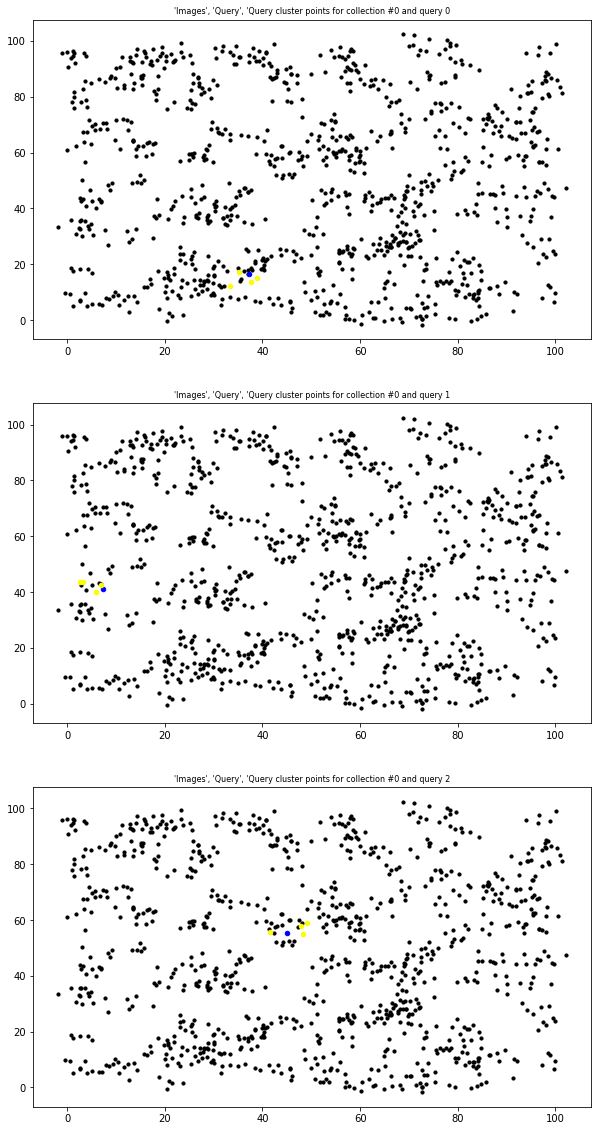

In [13]:
f = h5py.File("synthetic_dataset.h5",'r')
collectionNumber = 0
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
showQueryClusters(f, collectionNumber, 0)
plt.subplot(3,1,2)
showQueryClusters(f, collectionNumber, 1)
plt.subplot(3,1,3)
showQueryClusters(f, collectionNumber, 2)
f.close()

[(491, 0.8694128457961454), (879, 0.5183706916543014), (391, 0.4596834272636592), (966, 0.4549512374911924), (629, 0.44172723236426314), (429, 0.4289490317911736), (242, 0.41121653081843546), (884, 0.34327560907762233), (675, 0.33670422726226834), (90, 0.3250558204111118), (332, 0.32388751047443987), (833, 0.3170554384694171), (665, 0.266229750616439), (381, 0.2655648903835266), (605, 0.25725958670666893), (689, 0.24320666715325578), (213, 0.22880798687070317), (507, 0.2225714438173796), (469, 0.2202211952429572), (423, 0.21037592914526337)]
Selected data ground indices:  [491, 879, 391, 966, 629, 429, 242, 884, 675, 90, 332, 833, 665, 381, 605, 689, 213, 507, 469, 423]
Number of clusters in dataset =  201
Queries are in cluster numbers:  [145, 195, 16]
Summary point belongs to cluster:  101
Summary point belongs to cluster:  195
Summary point belongs to cluster:  170
Summary point belongs to cluster:  101
Summary point belongs to cluster:  101
Summary point belongs to cluster:  99
Sum

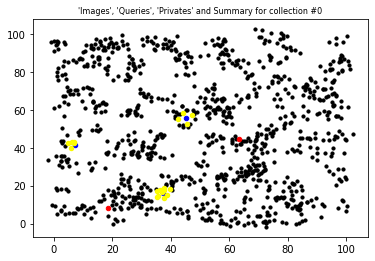

In [14]:
import submodlib.helper as helper
num_ground = 1000
query = [0,1,2]
f = h5py.File("synthetic_dataset.h5",'r')
collectionNumber = 0
budget = 20
mode="query"
obj = create_object(mode=mode, function="GC", n=num_ground,
              param=None, dataset=f, collection=collectionNumber, 
              query=query, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                param=None, dataset=f, collection=collectionNumber, 
                query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", 
                          stopIfZeroGain=False, stopIfNegativeGain=False)
print(greedyList)
showSummary(f, collectionNumber, greedyList)
fairness_score, relevance_score, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f, verbose=True)
print("Fairness: ", fairness_score)
print("Relevance: ", relevance_score)
print("Diversity: ", diversity_score)
print("Num zero gain: ", numZeroGain)
f.close()

# Experiments

In [ ]:
import csv
import submodlib.helper as helper
budgets = [10]
modes = ["joint"]
genericOptimizers = ["GC", "FL", "DSUM", "DMIN", "LOGDET"]
queryOptimizers = ["GC", "FL1", "FL2", "COM1", "COM2", "COM3", "LOGDET"]
privacyOptimizers = ["FL", "GC", "LOGDET"]
jointOptimizers = ["LOGDET"]
gcLambdas = [0, 0.5, 1, 2, 3, 4, 5, 6, 7]
logDetLambdas = [1]
num_ground = 1000
query = [0,1,2]
private = [3,4]
# magnificationEtas = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 10, 50, 100]
magnificationEtas = [0, 1, 3, 10, 50, 100]
queryDiversityEtas = [0, 1, 3, 10, 50, 100]
# queryDiversityEtas = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 10, 50, 100]
privacyHardness = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 10, 50, 100]
f = h5py.File("synthetic_dataset.h5",'r')
for mode in modes:
  if mode == "generic":
    generic_csv = [["function", "lambda", "eta", "nu", "budget", "diversity", "num_zero_gains"]]
    for genericOptimizer in genericOptimizers:
      if genericOptimizer == "GC":
        for gcLambda in gcLambdas:
          diversity_scores = {}
          numZeroGains = {}
          for collectionNumber in range(cn):
            obj = create_object(mode=mode, function="GC", n=num_ground,
                          param=gcLambda, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            for budget in budgets:
              print(f"Computing Generic-GC-GCLambda({gcLambda})-Collection({collectionNumber})-Budget({budget})")
              greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
              _, _, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
              if str(budget) in diversity_scores:
                diversity_scores[str(budget)] += diversity_score/cn
                numZeroGains[str(budget)] += numZeroGain/cn
              else:
                diversity_scores[str(budget)] = diversity_score/cn
                numZeroGains[str(budget)] = numZeroGain/cn
          for key in diversity_scores:
            generic_csv.append(["GC", gcLambda, "-", "-", key, diversity_scores[key], numZeroGains[key]])
      elif genericOptimizer == "LOGDET":
        for logDetLambda in logDetLambdas:
          diversity_scores = {}
          numZeroGains = {}
          for collectionNumber in range(cn):
            obj = create_object(mode=mode, function="LOGDET", n=num_ground,
                          param=logDetLambda, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            for budget in budgets:
              print(f"Computing Generic-LOGDET-LOGDETLambda({logDetLambda})-Collection({collectionNumber})-Budget({budget})")
              greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
              _, _, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
              if str(budget) in diversity_scores:
                diversity_scores[str(budget)] += diversity_score/cn
                numZeroGains[str(budget)] += numZeroGain/cn
              else:
                diversity_scores[str(budget)] = diversity_score/cn
                numZeroGains[str(budget)] = numZeroGain/cn
          for key in diversity_scores:
            generic_csv.append(["LOGDET", logDetLambda, "-", "-", key, diversity_scores[key], numZeroGains[key]])
      else:
        diversity_scores = {}
        numZeroGains = {}
        for collectionNumber in range(cn):
          obj = create_object(mode=mode, function=genericOptimizer, n=num_ground,
                        param=None, dataset=f, collection=collectionNumber, 
                        query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
          divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
          for budget in budgets:
            print(f"Computing Generic-{genericOptimizer}-Collection({collectionNumber})-Budget({budget})")
            greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
            _, _, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
            if str(budget) in diversity_scores:
              diversity_scores[str(budget)] += diversity_score/cn
              numZeroGains[str(budget)] += numZeroGain/cn
            else:
              diversity_scores[str(budget)] = diversity_score/cn
              numZeroGains[str(budget)] = numZeroGain/cn
        for key in diversity_scores:
          generic_csv.append([genericOptimizer, "-", "-", "-", key, diversity_scores[key], numZeroGains[key]])
    with open("generic.csv", "w") as wcsv:
      gdwriter = csv.writer(wcsv)
      gdwriter.writerows(generic_csv)
      wcsv.flush()
  elif mode=="query":
    query_csv = [["function", "lambda", "eta", "nu", "budget", "fairness", "relevance", "diversity", "num_zero_gains"]]
    for queryOptimizer in queryOptimizers:
      if queryOptimizer == "LOGDET":
        for logDetLambda in logDetLambdas:
          for magnificationEta in magnificationEtas:
            fairness_scores = {}
            relevance_scores = {}
            diversity_scores = {}
            numZeroGains = {}
            for collectionNumber in range(cn):
              obj = create_object(mode=mode, function="LOGDET", n=num_ground,
                            param=logDetLambda, dataset=f, collection=collectionNumber, 
                            query=query, private=None, magnificationEta=magnificationEta, privacyHardness=None, queryDiversityLambda=None)
              divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
              for budget in budgets:
                print(f"Computing Query-LOGDETMI-LOGDETLambda({logDetLambda})-Eta({magnificationEta})-Collection({collectionNumber})-Budget({budget})")
                greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
                fairness_score, relevance_score, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
                if str(budget) in diversity_scores:
                  fairness_scores[str(budget)] += fairness_score/cn
                  relevance_scores[str(budget)] += relevance_score/cn
                  diversity_scores[str(budget)] += diversity_score/cn
                  numZeroGains[str(budget)] += numZeroGain/cn
                else:
                  fairness_scores[str(budget)] = fairness_score/cn
                  relevance_scores[str(budget)] = relevance_score/cn
                  diversity_scores[str(budget)] = diversity_score/cn
                  numZeroGains[str(budget)] = numZeroGain/cn
            for key in diversity_scores:
              query_csv.append(["LOGDET", logDetLambda, magnificationEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
      elif queryOptimizer == "GC":
        fairness_scores = {}
        relevance_scores = {}
        diversity_scores = {}
        numZeroGains = {}
        for collectionNumber in range(cn):
          obj = create_object(mode=mode, function="GC", n=num_ground,
                        param=None, dataset=f, collection=collectionNumber, 
                        query=query, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
          divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
          for budget in budgets:
            print(f"Computing Query-GCMI-Collection({collectionNumber})-Budget({budget})")
            greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
            fairness_score, relevance_score, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
            if str(budget) in diversity_scores:
              fairness_scores[str(budget)] += fairness_score/cn
              relevance_scores[str(budget)] += relevance_score/cn
              diversity_scores[str(budget)] += diversity_score/cn
              numZeroGains[str(budget)] += numZeroGain/cn
            else:
              fairness_scores[str(budget)] = fairness_score/cn
              relevance_scores[str(budget)] = relevance_score/cn
              diversity_scores[str(budget)] = diversity_score/cn
              numZeroGains[str(budget)] = numZeroGain/cn
        for key in diversity_scores:
          query_csv.append(["GCMI", "-", "-", "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
      elif queryOptimizer == "FL1":
        for magnificationEta in magnificationEtas:
          fairness_scores = {}
          relevance_scores = {}
          diversity_scores = {}
          numZeroGains = {}
          for collectionNumber in range(cn):
            obj = create_object(mode=mode, function="FL1", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=query, private=None, magnificationEta=magnificationEta, privacyHardness=None, queryDiversityLambda=None)
            divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            for budget in budgets:
              print(f"Computing Query-FL1MI-Eta({magnificationEta})-Collection({collectionNumber})-Budget({budget})")
              greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
              fairness_score, relevance_score, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
              if str(budget) in diversity_scores:
                fairness_scores[str(budget)] += fairness_score/cn
                relevance_scores[str(budget)] += relevance_score/cn
                diversity_scores[str(budget)] += diversity_score/cn
                numZeroGains[str(budget)] += numZeroGain/cn
              else:
                fairness_scores[str(budget)] = fairness_score/cn
                relevance_scores[str(budget)] = relevance_score/cn
                diversity_scores[str(budget)] = diversity_score/cn
                numZeroGains[str(budget)] = numZeroGain/cn
          for key in diversity_scores:
            query_csv.append(["FL1", "-", magnificationEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
      elif queryOptimizer == "FL2" or queryOptimizer == "COM1" or queryOptimizer == "COM2" or queryOptimizer == "COM3":
        for queryDiversityEta in queryDiversityEtas:
          fairness_scores = {}
          relevance_scores = {}
          diversity_scores = {}
          numZeroGains = {}
          for collectionNumber in range(cn):
            obj = create_object(mode=mode, function=queryOptimizer, n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=query, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=queryDiversityEta)
            divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            for budget in budgets:
              print(f"Computing Query-{queryOptimizer}-Eta({queryDiversityEta})-Collection({collectionNumber})-Budget({budget})")
              greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
              fairness_score, relevance_score, diversity_score, _, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
              if str(budget) in diversity_scores:
                fairness_scores[str(budget)] += fairness_score/cn
                relevance_scores[str(budget)] += relevance_score/cn
                diversity_scores[str(budget)] += diversity_score/cn
                numZeroGains[str(budget)] += numZeroGain/cn
              else:
                fairness_scores[str(budget)] = fairness_score/cn
                relevance_scores[str(budget)] = relevance_score/cn
                diversity_scores[str(budget)] = diversity_score/cn
                numZeroGains[str(budget)] = numZeroGain/cn
          for key in diversity_scores:
            query_csv.append([queryOptimizer, "-", queryDiversityEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
    with open("query.csv", "w") as wcsv:
      gdwriter = csv.writer(wcsv)
      gdwriter.writerows(query_csv)
      wcsv.flush()
  elif mode == "private":
    private_csv = [["function", "lambda", "eta", "nu", "budget", "diversity", "irrelevance", "num_zero_gains"]]
    for privacyOptimizer in privacyOptimizers:
      if privacyOptimizer == "GC":
        for gcLambda in gcLambdas:
          for nu in privacyHardness:
            diversity_scores = {}
            irrelevance_scores = {}
            numZeroGains = {}
            for collectionNumber in range(cn):
              obj = create_object(mode=mode, function="GC", n=num_ground,
                            param=gcLambda, dataset=f, collection=collectionNumber, 
                            query=None, private=private, magnificationEta=None, privacyHardness=nu, queryDiversityLambda=None)
              divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
              for budget in budgets:
                print(f"Computing Private-GCCG-GCLambda({gcLambda})-Nu({nu})-Collection({collectionNumber})-Budget({budget})")
                greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
                _, _, diversity_score, irrelevance_score, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
                if str(budget) in diversity_scores:
                  irrelevance_scores[str(budget)] += irrelevance_score/cn
                  diversity_scores[str(budget)] += diversity_score/cn
                  numZeroGains[str(budget)] += numZeroGain/cn
                else:
                  irrelevance_scores[str(budget)] = irrelevance_score/cn
                  diversity_scores[str(budget)] = diversity_score/cn
                  numZeroGains[str(budget)] = numZeroGain/cn
            for key in diversity_scores:
              private_csv.append(["GC", gcLambda, "-", nu, key, diversity_scores[key], irrelevance_scores[key], numZeroGains[key]])
      elif privacyOptimizer == "LOGDET":
        for logDetLambda in logDetLambdas:
          for nu in privacyHardness:
            diversity_scores = {}
            irrelevance_scores = {}
            numZeroGains = {}
            for collectionNumber in range(cn):
              obj = create_object(mode=mode, function="LOGDET", n=num_ground,
                            param=logDetLambda, dataset=f, collection=collectionNumber, 
                            query=None, private=private, magnificationEta=None, privacyHardness=nu, queryDiversityLambda=None)
              divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
              for budget in budgets:
                print(f"Computing Private-LogDetCG-logDetLambda({logDetLambda})-Nu({nu})-Collection({collectionNumber})-Budget({budget})")
                greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
                _, _, diversity_score, irrelevance_score, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
                if str(budget) in diversity_scores:
                  irrelevance_scores[str(budget)] += irrelevance_score/cn
                  diversity_scores[str(budget)] += diversity_score/cn
                  numZeroGains[str(budget)] += numZeroGain/cn
                else:
                  irrelevance_scores[str(budget)] = irrelevance_score/cn
                  diversity_scores[str(budget)] = diversity_score/cn
                  numZeroGains[str(budget)] = numZeroGain/cn
            for key in diversity_scores:
              private_csv.append(["LogDet", logDetLambda, "-", nu, key, diversity_scores[key], irrelevance_scores[key], numZeroGains[key]])
      elif privacyOptimizer == "FL":
        for nu in privacyHardness:
          diversity_scores = {}
          irrelevance_scores = {}
          numZeroGains = {}
          for collectionNumber in range(cn):
            obj = create_object(mode=mode, function="FL", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=private, magnificationEta=None, privacyHardness=nu, queryDiversityLambda=None)
            divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
            for budget in budgets:
              print(f"Computing Private-FLCG-Nu({nu})-Collection({collectionNumber})-Budget({budget})")
              greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
              _, _, diversity_score, irrelevance_score, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
              if str(budget) in diversity_scores:
                irrelevance_scores[str(budget)] += irrelevance_score/cn
                diversity_scores[str(budget)] += diversity_score/cn
                numZeroGains[str(budget)] += numZeroGain/cn
              else:
                irrelevance_scores[str(budget)] = irrelevance_score/cn
                diversity_scores[str(budget)] = diversity_score/cn
                numZeroGains[str(budget)] = numZeroGain/cn
          for key in diversity_scores:
            private_csv.append(["FL", "-", "-", nu, key, diversity_scores[key], irrelevance_scores[key], numZeroGains[key]])
    with open("private.csv", "w") as wcsv:
      gdwriter = csv.writer(wcsv)
      gdwriter.writerows(private_csv)
      wcsv.flush()
  else:  
    joint_csv = [["function", "lambda", "eta", "nu", "budget", "fairness", "relevance", "diversity", "irrelevance", "num_zero_gains"]]
    for jointOptimizer in jointOptimizers:
      if jointOptimizer == "LOGDET":
        for logDetLambda in logDetLambdas:
          for magnificationEta in magnificationEtas:
            for nu in privacyHardness:
              fairness_scores = {}
              relevance_scores = {}
              diversity_scores = {}
              irrelevance_scores = {}
              numZeroGains = {}
              for collectionNumber in range(cn):
                obj = create_object(mode=mode, function="LOGDET", n=num_ground,
                              param=logDetLambda, dataset=f, collection=collectionNumber, 
                              query=query, private=private, magnificationEta=magnificationEta, privacyHardness=nu, queryDiversityLambda=None)
                divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
                for budget in budgets:
                  print(f"Computing Joint-LogDetCMI-LogDetLambda({logDetLambda})-Eta({magnificationEta})-Nu({nu})-Collection({collectionNumber})-Budget({budget})")
                  greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
                  fairness_score, relevance_score, diversity_score, irrelevance_score, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
                  if str(budget) in diversity_scores:
                    fairness_scores[str(budget)] += fairness_score/cn
                    relevance_scores[str(budget)] += relevance_score/cn
                    irrelevance_scores[str(budget)] += irrelevance_score/cn
                    diversity_scores[str(budget)] += diversity_score/cn
                    numZeroGains[str(budget)] += numZeroGain/cn
                  else:
                    fairness_scores[str(budget)] = fairness_score/cn
                    relevance_scores[str(budget)] = relevance_score/cn
                    irrelevance_scores[str(budget)] = irrelevance_score/cn
                    diversity_scores[str(budget)] = diversity_score/cn
                    numZeroGains[str(budget)] = numZeroGain/cn
              for key in diversity_scores:
                joint_csv.append(["LOGDET", logDetLambda, magnificationEta, nu, key, fairness_scores[key], relevance_scores[key], diversity_scores[key], irrelevance_scores[key], numZeroGains[key]])
      elif jointOptimizer == "FL":
        for magnificationEta in magnificationEtas:
          for nu in privacyHardness:
            fairness_scores = {}
            relevance_scores = {}
            diversity_scores = {}
            irrelevance_scores = {}
            numZeroGains = {}
            for collectionNumber in range(cn):
              obj = create_object(mode=mode, function="FL", n=num_ground,
                            param=None, dataset=f, collection=collectionNumber, 
                            query=query, private=private, magnificationEta=magnificationEta, privacyHardness=nu, queryDiversityLambda=None)
              divobj = create_object(mode="generic", function="DSUM", n=num_ground,
                          param=None, dataset=f, collection=collectionNumber, 
                          query=None, private=None, magnificationEta=None, privacyHardness=None, queryDiversityLambda=None)
              for budget in budgets:
                print(f"Computing Joint-FLCMI-Eta({magnificationEta})-Nu({nu})-Collection({collectionNumber})-Budget({budget})")
                greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
                fairness_score, relevance_score, diversity_score, irrelevance_score, numZeroGain = computeScores(divobj, budget, greedyList, mode, collectionNumber, f)
                if str(budget) in diversity_scores:
                  fairness_scores[str(budget)] += fairness_score/cn
                  relevance_scores[str(budget)] += relevance_score/cn
                  irrelevance_scores[str(budget)] += irrelevance_score/cn
                  diversity_scores[str(budget)] += diversity_score/cn
                  numZeroGains[str(budget)] += numZeroGain/cn
                else:
                  fairness_scores[str(budget)] = fairness_score/cn
                  relevance_scores[str(budget)] = relevance_score/cn
                  irrelevance_scores[str(budget)] = irrelevance_score/cn
                  diversity_scores[str(budget)] = diversity_score/cn
                  numZeroGains[str(budget)] = numZeroGain/cn
            for key in diversity_scores:
              joint_csv.append(["FL", "-", magnificationEta, nu, key, fairness_scores[key], relevance_scores[key], diversity_scores[key], irrelevance_scores[key], numZeroGains[key]])
    with open("joint.csv", "w") as wcsv:
      gdwriter = csv.writer(wcsv)
      gdwriter.writerows(joint_csv)
      wcsv.flush()
f.close()

Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(0)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(1)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(2)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(3)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(4)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(5)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(6)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(7)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(8)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0)-Collection(9)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0.3)-Collection(0)-Budget(10)
Computing Joint-LogDetCMI-LogDetLambda(1)-Eta(0)-Nu(0.3)-Collection(1)-Budget(10)
Computing Joint-LogDetCMI-LogDetLamb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Generic Results

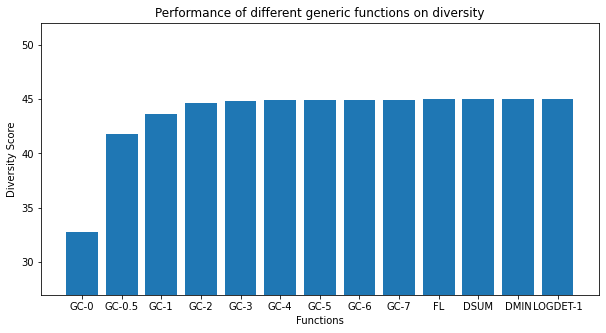

In [19]:
import matplotlib.pyplot as plt
import csv
import math
functions = []
diversity_scores = []
with open('/content/drive/MyDrive/generic.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  header_row = True
  for row in csv_reader:
      if header_row:
          header_row=False
          pass
      else:
          if row[0]=="GC" or row[0]=="LOGDET":
            name = row[0]+"-"+row[1]
          else:
            name = row[0]
          functions.append(name)
          diversity_scores.append(round(float(row[5]),4))
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(functions,diversity_scores)
# plt.show()
fig = plt.figure(figsize = (10, 5))
low = min(diversity_scores)
high = max(diversity_scores)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.bar(functions, diversity_scores)
plt.xlabel("Functions")
plt.ylabel("Diversity Score")
plt.title("Performance of different generic functions on diversity")
plt.show()

# Query Results

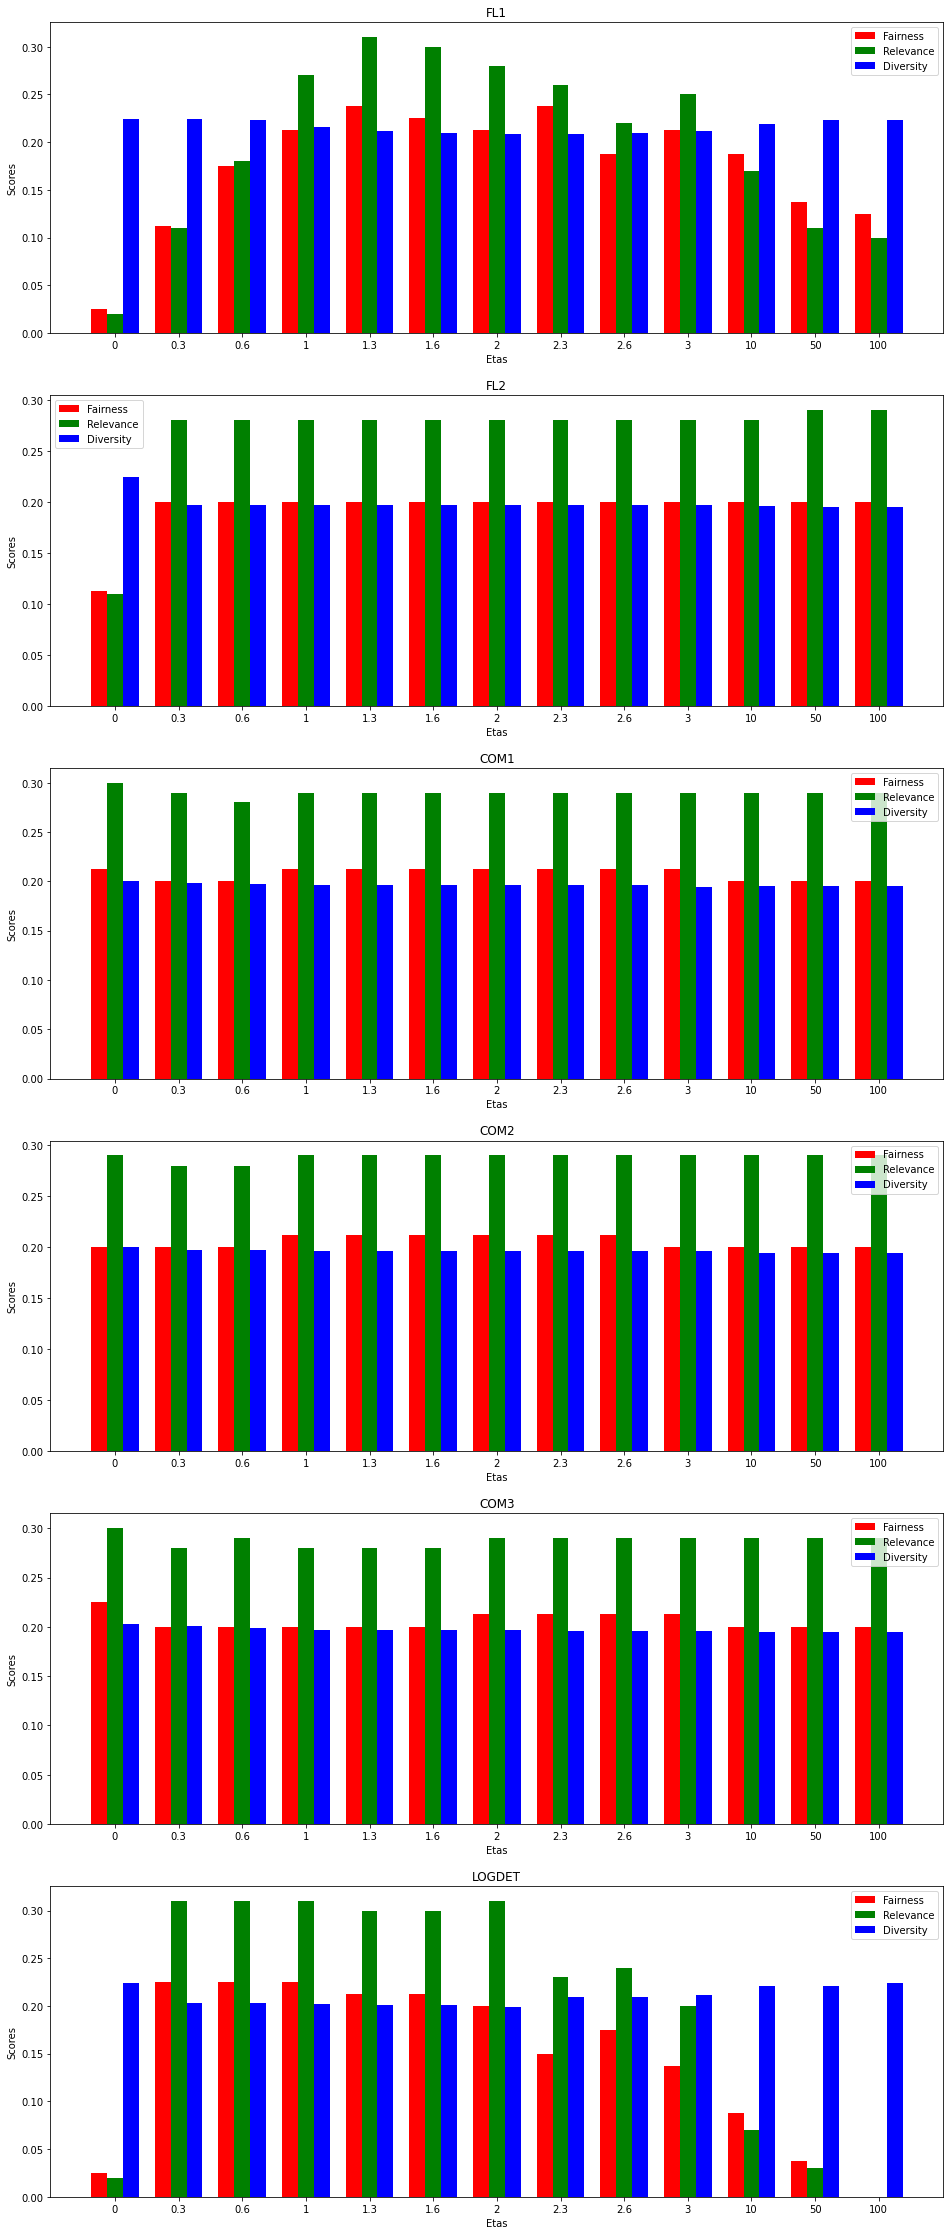

In [33]:
import matplotlib.pyplot as plt
import csv
import numpy as np
row_index = 0
col_index = 1
current_name = ""
plt.figure(figsize = (16, 40))
with open('/content/drive/MyDrive/query.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  ignore_row = True
  first = True
  for row in csv_reader:
      if ignore_row or row[2]=="-":
          ignore_row=False
          pass
      else:
        # print("Row: ", row[0])
        new_name = row[0]
        if new_name != current_name:
          if not first:
            # print(current_name)
            # print(fairness_scores)
            # print(relevance_scores)
            # print(diversity_scores)
            N = len(etas)
            ind = np.arange(N) 
            width = 0.25
            plt.subplot(6,1,row_index*1+col_index)
            # plt.plot(etas, fairness_scores)
            # plt.plot(etas, relevance_scores)
            # plt.plot(etas, diversity_scores)
            bar1 = plt.bar(ind, fairness_scores, width, color = 'r')
            bar2 = plt.bar(ind+width, relevance_scores, width, color='g')
            bar3 = plt.bar(ind+width*2, diversity_scores, width, color = 'b')
            plt.xlabel("Etas")
            plt.ylabel("Scores")
            plt.title(current_name)
            plt.xticks(ind+width,etas)
            plt.legend( (bar1, bar2, bar3), ('Fairness', 'Relevance', 'Diversity') )
            col_index += 1
            if col_index == 2:
                row_index += 1
                col_index = 1
          first = False
          etas = []
          fairness_scores = []
          relevance_scores = []
          diversity_scores = []
          current_name = new_name
          # etas.append(float(row[2]))
          etas.append(row[2])
          fairness_scores.append(round(float(row[5]),4))
          relevance_scores.append(round(float(row[6]),4))
          diversity_scores.append(round(float(row[7])/200,4))
        else:
          # etas.append(float(row[2]))
          etas.append(row[2])
          fairness_scores.append(round(float(row[5]),4))
          relevance_scores.append(round(float(row[6]),4))
          diversity_scores.append(round(float(row[7])/200,4))
  # print(current_name)
  # print(fairness_scores)
  # print(relevance_scores)
  # print(diversity_scores)
  # plt.subplot(2,3,row_index*3+col_index)
  # plt.plot(etas, fairness_scores)
  # plt.plot(etas, relevance_scores)
  # plt.plot(etas, diversity_scores)
  # plt.title(current_name)
  N = len(etas)
  ind = np.arange(N) 
  width = 0.25
  plt.subplot(6,1,row_index*1+col_index)
  # plt.plot(etas, fairness_scores)
  # plt.plot(etas, relevance_scores)
  # plt.plot(etas, diversity_scores)
  bar1 = plt.bar(ind, fairness_scores, width, color = 'r')
  bar2 = plt.bar(ind+width, relevance_scores, width, color='g')
  bar3 = plt.bar(ind+width*2, diversity_scores, width, color = 'b')
  plt.xlabel("Etas")
  plt.ylabel("Scores")
  plt.title(current_name)
  plt.xticks(ind+width,etas)
  plt.legend( (bar1, bar2, bar3), ('Fairness', 'Relevance', 'Diversity') )

# Comparison among functions for $\eta=1$

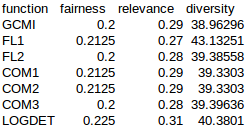

([<matplotlib.axis.XTick at 0x7fcfac6fb1d0>,
 [Text(0, 0, 'GCMI'),
  Text(0, 0, 'FL1'),
  Text(0, 0, 'FL2'),
  Text(0, 0, 'COM1'),
  Text(0, 0, 'COM2'),
  Text(0, 0, 'COM3'),
  Text(0, 0, 'LOGDET')])

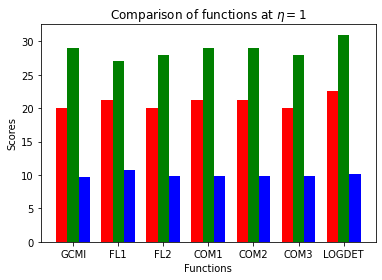

In [38]:
functions = ["GCMI", "FL1", "FL2", "COM1", "COM2", "COM3", "LOGDET"]
fairness_scores = [0.2, 0.2125, 0.2, 0.2125, 0.2125, 0.2, 0.225]
relevance_scores = [0.29, 0.27, 0.28, 0.29, 0.29, 0.28, 0.31]
diversity_scores = [0.195, 0.216, 0.197, 0.197, 0.197, 0.197, 0.202]


N = len(functions)
ind = np.arange(N) 
width = 0.25
bar1 = plt.bar(ind, [100* x for x in fairness_scores], width, color = 'r')
bar2 = plt.bar(ind+width, [100* x for x in relevance_scores], width, color='g')
bar3 = plt.bar(ind+width*2, [50 * x for x in diversity_scores], width, color = 'b')
plt.xlabel("Functions")
plt.ylabel("Scores")
plt.title("Comparison of functions at $\eta=1$")
plt.xticks(ind+width,functions)
# plt.legend( (bar1, bar2, bar3), ('Fairness', 'Relevance', 'Diversity') )